In [48]:
import yfinance as yf
import pandas as pd
import numpy as np
from scipy.signal import argrelextrema
from ta.momentum import RSIIndicator
from ta.trend import MACD
from ta.volatility import BollingerBands
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
import mplfinance as mpf
import seaborn as sns
import matplotlib.gridspec as gridspec 

In [49]:
TICKER = 'AAPL'

def prepare_data():
    stock_data = yf.download(TICKER, start='2014-01-01', end='2025-01-01')
    
    df = stock_data.copy()
    df.columns = df.columns.get_level_values(0)
    df = df.rename(columns={'Vol': 'Volume'})

    df['normalized'] = (df['Close'] - df['Low']) / (df['High'] - df['Low'].replace(0, np.nan)).fillna(0.5)
    
    def calculate_slope(series):
        return np.polyfit(np.arange(len(series)), series, 1)[0] if len(series) > 1 else np.nan
    
    windows = [3, 5, 10, 20]
    for w in windows:
        df[f'regression_{w}d'] = df['Close'].rolling(window=w, min_periods=2).apply(calculate_slope, raw=True)

    df['RSI'] = RSIIndicator(df['Close'], window=14).rsi()
    macd = MACD(df['Close'])
    df['MACD'] = macd.macd()
    df['MACD_signal'] = macd.macd_signal()
    df['Volatility'] = df['Close'].pct_change().rolling(5).std()
    
    local_min = argrelextrema(df['Close'].values, np.less, order=5)[0]
    local_max = argrelextrema(df['Close'].values, np.greater, order=5)[0]
    
    df['target'] = np.nan
    df.iloc[local_min, df.columns.get_loc('target')] = 0  # Buy signals
    df.iloc[local_max, df.columns.get_loc('target')] = 1  # Sell signals

    features = ['normalized', 'Volume', 'RSI', 'MACD', 'Volatility'] + [f'regression_{w}d' for w in windows]
    model_df = df.dropna(subset=features + ['target']).copy()
    
    return model_df

try:
    model_df = prepare_data()
    print("Data preparation successful!")
    print("Sample features:")
    print(model_df[['Close', 'RSI', 'MACD', 'regression_5d', 'target']].tail())
except Exception as e:
    print(f"Data error: {str(e)}")

[*********************100%***********************]  1 of 1 completed


Data preparation successful!
Sample features:
Price            Close        RSI      MACD  regression_5d  target
Date                                                              
2024-09-30  232.743942  64.902874  1.878915       1.266609     1.0
2024-10-07  221.446365  44.971131  0.853936      -0.901012     0.0
2024-10-21  236.220108  63.419995  2.646353       0.847067     1.0
2024-11-04  221.766006  38.301466 -0.244881      -3.047647     0.0
2024-12-26  259.019989  76.452865  6.306946       2.217000     1.0


In [50]:
def train_model(model_df):
    features = ['normalized', 'Volume', 'RSI', 'MACD', 'Volatility',
               'regression_3d', 'regression_5d', 'regression_10d', 'regression_20d']

    missing = [f for f in features if f not in model_df.columns]
    if missing:
        raise ValueError(f"Missing features: {missing}")
    
    X = model_df[features]
    y = model_df['target'].astype(int)

    tscv = TimeSeriesSplit(n_splits=5)
    metrics = []
    
    for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        model = RandomForestClassifier(
            n_estimators=200,
            class_weight='balanced',
            max_depth=5,
            random_state=42
        )
        model.fit(X_train, y_train)
        
        y_proba = model.predict_proba(X_test)[:, 1]
        y_pred = (y_proba > 0.4).astype(int)
        
        report = classification_report(y_test, y_pred, output_dict=True)
        metrics.append({
            'fold': fold,
            'report': report,
            'confusion': confusion_matrix(y_test, y_pred)
        })
    
    avg_recall = np.mean([m['report']['1']['recall'] for m in metrics])
    print(f"\nAverage Sell Recall (5-fold CV): {avg_recall:.1%}")
    
    final_model = RandomForestClassifier(
        n_estimators=200,
        class_weight='balanced',
        max_depth=5,
        random_state=42
    ).fit(X, y)
    
    plt.figure(figsize=(10,5))
    importance = pd.Series(final_model.feature_importances_, index=features)
    importance.sort_values().plot(kind='barh')
    plt.title('Feature Importance')
    plt.show()
    
    plt.figure(figsize=(6,4))
    sns.heatmap(metrics[-1]['confusion'], annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix (Last Fold)')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    return final_model, model_df, features 

In [51]:
class Backtester:
    def __init__(self, initial_balance=3000):
        self.initial_balance = initial_balance
        self.reset()
        
    def reset(self):
        self.cash = self.initial_balance
        self.shares = 0
        self.trades = []
        self.portfolio = [self.initial_balance]
        self.peak = self.initial_balance
        self.drawdown = 0
        self.drawdown_history = [] 
    def run(self, data, model, features, threshold=0.4):
        self.reset()
        data = data.copy()
        
        data['pred_proba'] = model.predict_proba(data[features])[:, 1]
        data['signal'] = (data['pred_proba'] > threshold).astype(int)
        
        for idx, row in data.iterrows():
            current_value = self.cash + self.shares * row['Close']
            self.portfolio.append(current_value)
            
            self.peak = max(self.peak, current_value)
            current_drawdown = (self.peak - current_value)/self.peak
            self.drawdown = max(self.drawdown, current_drawdown)
            self.drawdown_history.append(current_drawdown)  # Store historical
            
            if self.shares == 0 and row['signal'] == 0:
                # Buy
                self.shares = self.cash / row['Close']
                self.cash = 0
                self.trades.append({'type': 'buy', 'date': idx, 'price': row['Close']})
                
            elif self.shares > 0 and row['signal'] == 1:
                # Sell
                self.cash = self.shares * row['Close']
                self.shares = 0
                self.trades.append({
                    'type': 'sell',
                    'date': idx,
                    'price': row['Close'],
                    'profit': self.cash - self.initial_balance
                })
        
        return self.trades, self.portfolio[1:]

In [52]:
def plot_strategy_analysis(name, trades, portfolio, drawdowns, data, initial_balance):
    test_data = data[data.index >= '2023-01-01']
    buy_dates = [t['date'] for t in trades if t['type'] == 'buy']
    sell_dates = [t['date'] for t in trades if t['type'] == 'sell']
    
    plt.figure(figsize=(18, 16))
    gs = gridspec.GridSpec(6, 2, height_ratios=[2, 1, 1, 1, 1, 1])
    
    ax1 = plt.subplot(gs[0, :])
    ax1.plot(test_data['Close'], color='navy', lw=1.5, label='Price')
    
    for bd in buy_dates:
        ax1.axvspan(bd - pd.Timedelta(hours=12), bd + pd.Timedelta(hours=12), 
                   facecolor='lime', alpha=0.2)
    ax1.scatter(buy_dates, test_data.loc[buy_dates, 'Close'], 
                marker='^', color='darkgreen', s=120, ec='white', 
                linewidth=1, label='Buy', zorder=3)
    
    ax1.scatter(sell_dates, test_data.loc[sell_dates, 'Close'],
                marker='v', color='maroon', s=120, ec='white', 
                linewidth=1, label='Sell', zorder=3)
    ax1.set_title(f'{name} - Trading Signals', fontsize=14)
    ax1.legend()
    ax1.grid(alpha=0.3)

    ax2 = plt.subplot(gs[1, :])
    win_dates = [t['date'] for t in trades if t['type'] == 'sell' and t['profit'] > 0]
    loss_dates = [t['date'] for t in trades if t['type'] == 'sell' and t['profit'] <= 0]
    
    ax2.plot(test_data['Close'], color='gray', alpha=0.4, label='Price')
    ax2.scatter(win_dates, test_data.loc[win_dates, 'Close'], 
               color='lime', s=50, label='Win')
    ax2.scatter(loss_dates, test_data.loc[loss_dates, 'Close'],
               color='red', s=50, label='Loss')
    ax2.set_title('Win/Loss Trade Outcomes', fontsize=12)
    ax2.legend()
    ax2.grid(alpha=0.3)

    ax3 = plt.subplot(gs[2, :])
    ax3.plot(test_data['MACD'], label='MACD', color='blue')
    ax3.plot(test_data['MACD_signal'], label='Signal', color='orange')
    ax3.axhline(0, color='grey', ls='--')
    ax3.set_title('MACD', fontsize=12)
    ax3.grid(alpha=0.3)
    
    ax4 = plt.subplot(gs[3, :])
    ax4.plot(test_data['RSI'], color='purple')
    ax4.axhline(30, color='red', ls='--')
    ax4.axhline(70, color='red', ls='--')
    ax4.set_ylim(0, 100)
    ax4.set_title('RSI', fontsize=12)
    ax4.grid(alpha=0.3)
    
    ax5 = plt.subplot(gs[4, 0])
    ax5.plot(portfolio, color='darkgreen', lw=1.5)
    ax5.set_title('Portfolio Value', fontsize=12)
    ax5.grid(alpha=0.3)
    
    ax6 = plt.subplot(gs[4, 1])
    ax6.plot([d*100 for d in drawdowns], color='maroon')
    ax6.set_title('Drawdown (%)', fontsize=12)
    ax6.grid(alpha=0.3)
    
    ax7 = plt.subplot(gs[5, 0])
    profits = [t['profit'] for t in trades if t['type'] == 'sell']
    win_rate = sum(p > 0 for p in profits)/len(profits) if profits else 0
    ax7.pie([win_rate, 1-win_rate], labels=['Win', 'Loss'],
            colors=['#2ecc71', '#e74c3c'], autopct='%1.1f%%')
    ax7.set_title('Win/Loss Ratio', fontsize=12)

    print(f"\n{name} Performance Summary:")
    print(f"Initial Balance: ${initial_balance:,.2f}")
    print(f"Final Balance: ${portfolio[-1]:,.2f}")
    print(f"Total Return: {((portfolio[-1]/initial_balance)-1)*100:.2f}%")
    print(f"Max Drawdown: {max(drawdowns)*100:.1f}%")
    print(f"Win Rate: {win_rate:.1%}")
    print(f"Total Trades: {len(trades)//2}\n")
    
    plt.tight_layout()
    plt.show()


Average Sell Recall (5-fold CV): 100.0%


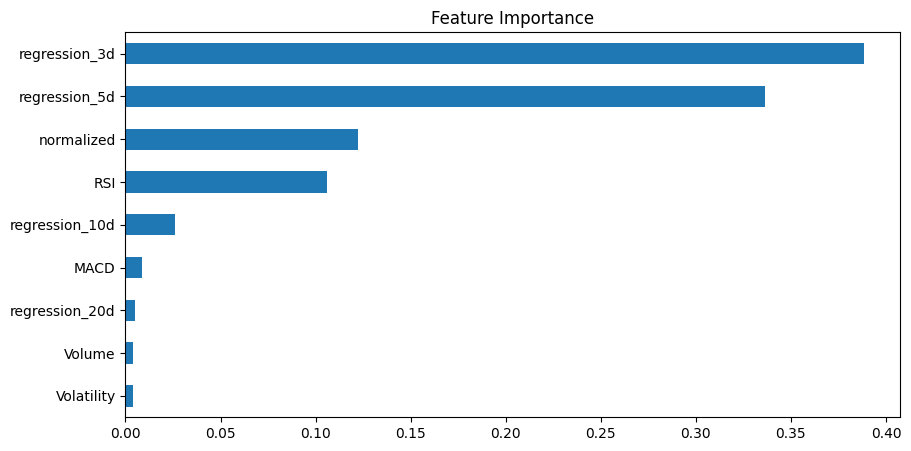

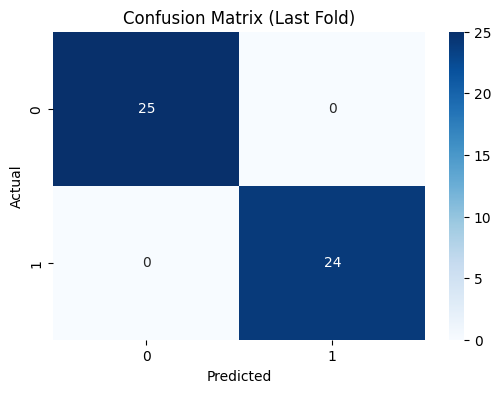


AAPL ML Strategy Performance Summary:
Initial Balance: $3,000.00
Final Balance: $22,783.57
Total Return: 659.45%
Max Drawdown: 0.0%
Win Rate: 100.0%
Total Trades: 23



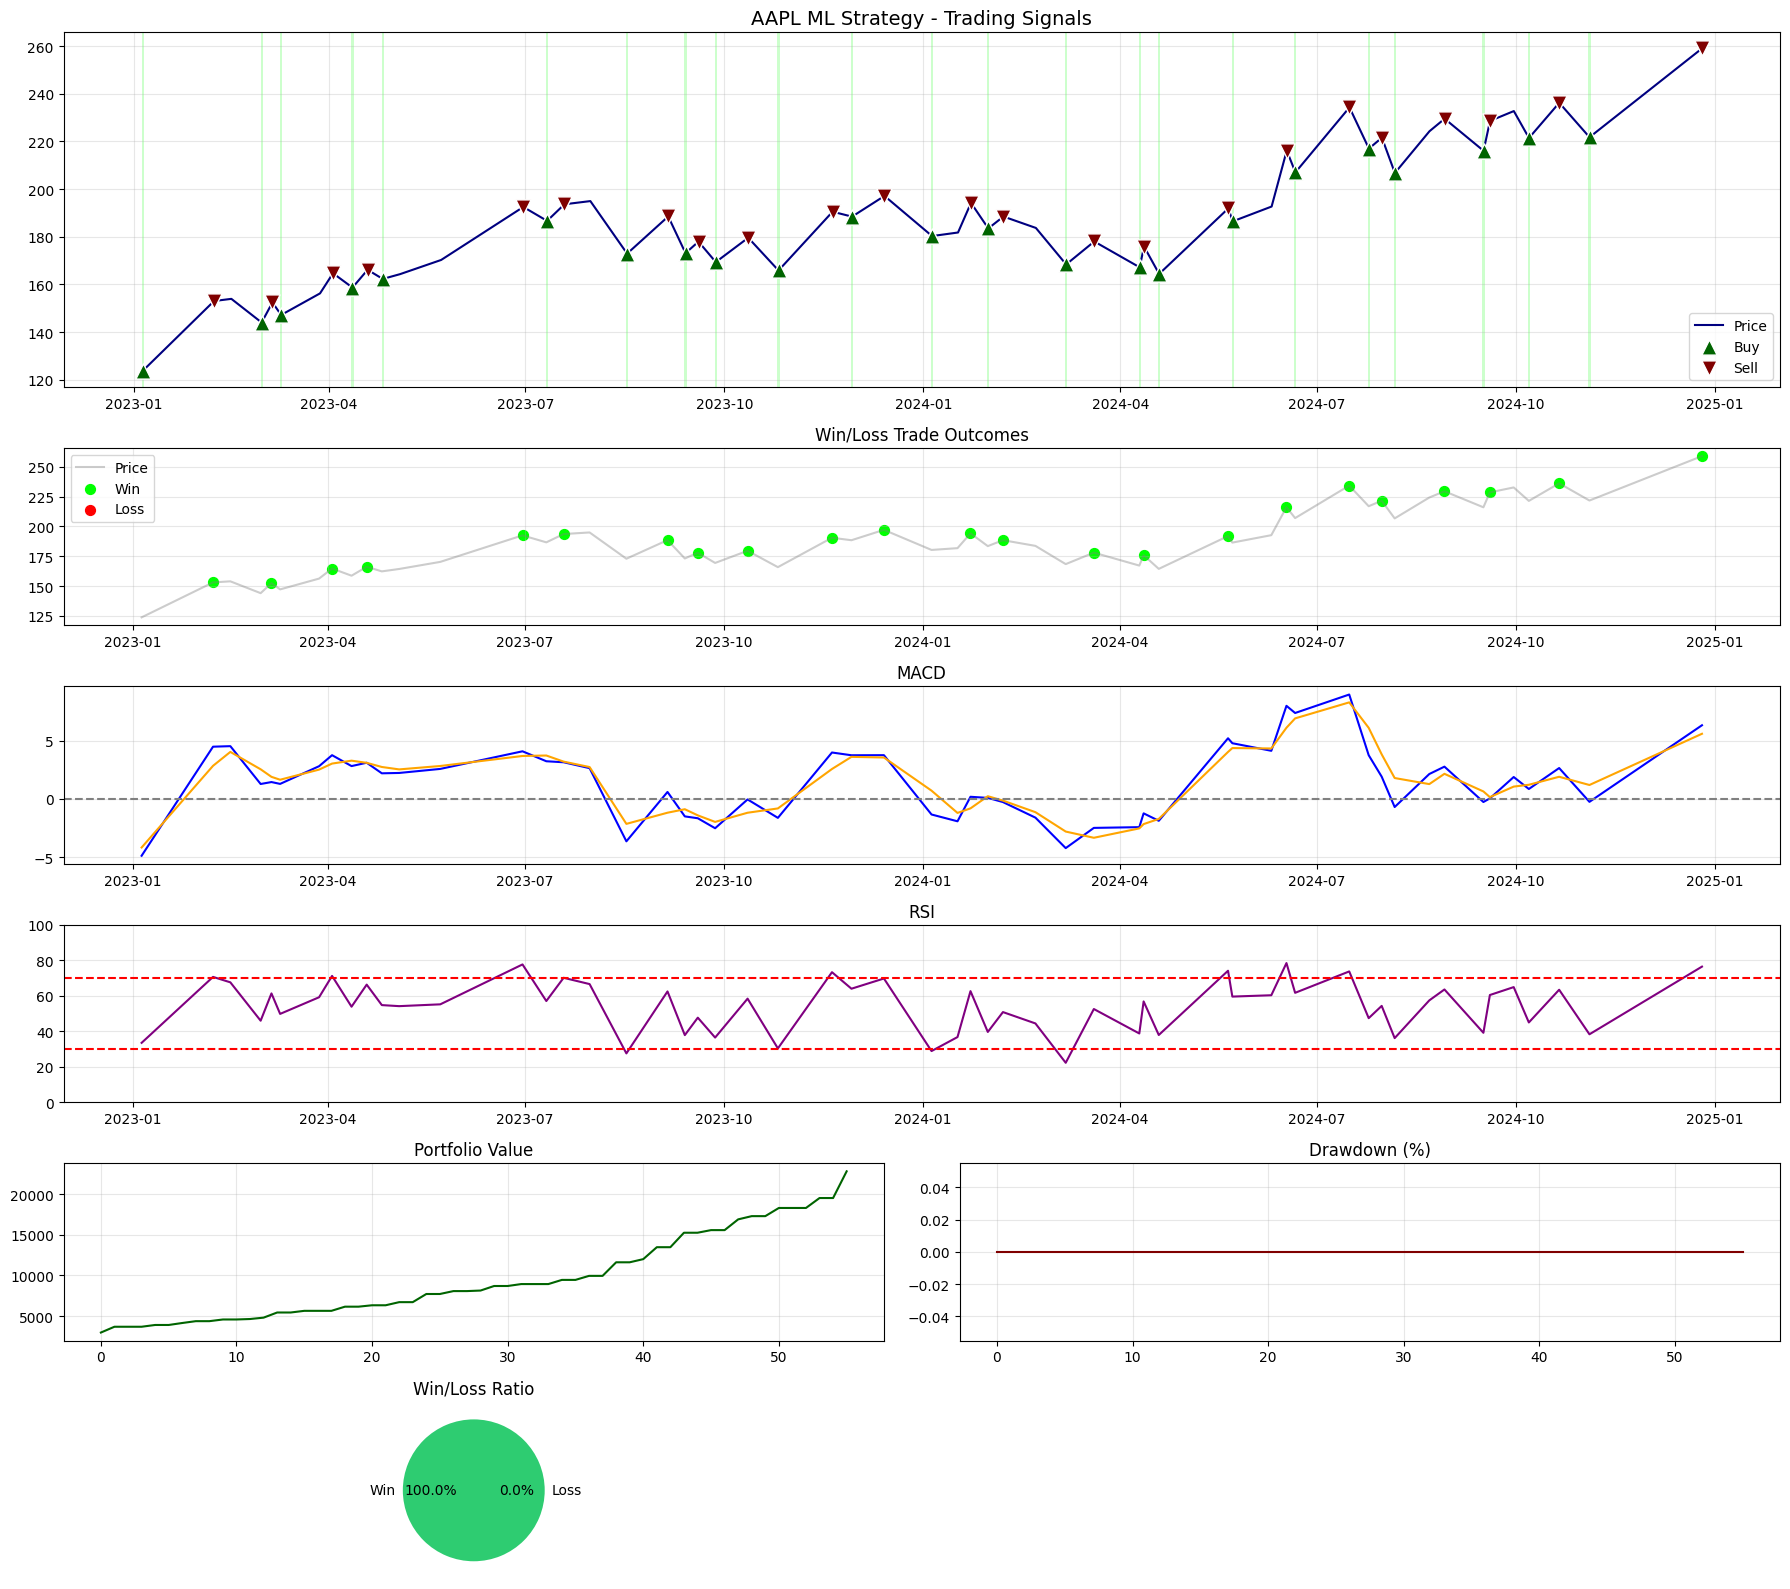

In [53]:
try:
    model, prepared_df, features = train_model(model_df)  
    
    test_data = prepared_df[prepared_df.index >= '2023-01-01'].copy()
    missing_test = [f for f in features if f not in test_data.columns]
    if missing_test:
        raise ValueError(f"Test data missing features: {missing_test}")
    
    bt = Backtester()
    trades, portfolio = bt.run(test_data, model, features)
    
    drawdown_series = pd.Series(bt.drawdown_history, index=test_data.index)
    
    plot_strategy_analysis(
        name=f"{TICKER} ML Strategy",
        trades=trades,
        portfolio=portfolio,
        drawdowns=drawdown_series.tolist(),
        data=prepared_df,
        initial_balance=3000
    )

except Exception as e:
    print(f"\nExecution error: {str(e)}")